# Calcul Numeric - Tema 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## 1. Minimizarea funcțiilor de două variabile

Începem prin a implementa funcția dată în Python:

In [2]:
def f(x, y):
    return 24.5 * (x**2) - (49 * x * y) - 8 * x + 42.5 * (y**2) - 4 * y

Afișăm graficul ei 3D:

<IPython.core.display.Javascript object>


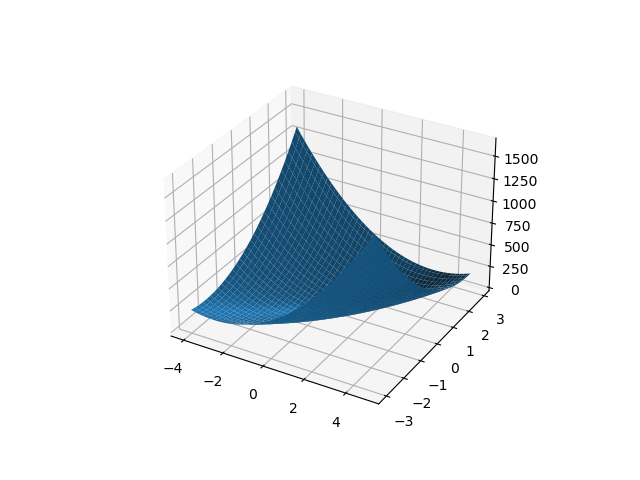

In [3]:
fig = plt.figure('Reprezentarea grafică a funcției')
ax = fig.add_subplot(projection='3d')

step = 0.1
X, Y = np.mgrid[-4:5:step, -3:3:step]

Z = f(X, Y)

ax.plot_surface(X, Y, Z)

plt.show()

Calculăm derivatele parțiale ale funcției:
$$
\begin{align*}
    \frac{\partial f}{\partial x} &= 49 x - 49 y - 8 \\
    \frac{\partial f}{\partial y} &= - 49 x + 85 y - 4
\end{align*}
$$

Scriem sistemul de ecuații liniare asociat:

In [4]:
A = np.array([
    [49, -49],
    [-49, 85]
], dtype=float)

b = np.array([
    [8],
    [4]
], dtype=float)

Pentru a admite un punct de minim unic, trebuie ca matricea $A$ să fie simetrică și pozitiv definită.

In [5]:
def simetrica(M):
    "Verifică dacă matricea `M` este simetrică."
    return np.all(M == M.T)

def pozitiv_definita(M):
    "Verifică ca matricea `M` să fie pozitiv definită."
    for i in range(M.shape[0]):
        # Folosesc criteriul lui Sylvester,
        # calculez determinanții minorilor principali
        if np.linalg.det(M[:i, :i]) <= 0:
            return False
    return True


print("Simetrică:", simetrica(A))
print("Pozitiv-definită:", pozitiv_definita(A))

Simetrică: True
Pozitiv-definită: True


### Metoda pasului descendent

Rezolvăm sistemul plecând de la un punct inițial $x_0$, și mergând tot timpul în direcția care minimizează cel mai mult forma pătratică asociată matricii $A$ (adică în direcția gradientului).

In [6]:
# Aleg un punct inițial interesant
x = np.array([[-3], [2]])

# Rețin punctele prin care trec
points_gradient_descent = [x]

residue = b - A @ x

# Ne oprim dacă norma reziduului scade sub această valoare
STOPPING_EPSILON = 1e-7

# Norma folosită este L2
norm = lambda x: np.linalg.norm(x, ord=2)

num_iterations = 0

while norm(residue) > STOPPING_EPSILON:
    # Determin cât de mare trebuie să fie următorul pas
    learning_rate = (residue.T @ residue) / (residue.T @ A @ residue)

    x = x + learning_rate * residue
    residue = b - A @ x

    points_gradient_descent.append(x)
    num_iterations += 1

print("Număr de iterații:", num_iterations)
print("Punct de minim:", x.ravel())

Număr de iterații: 13
Punct de minim: [0.49659864 0.33333333]


### Metoda gradienților conjugați

Asemănătoare cu metoda de mai sus, dar tot timpul mergem cât de mult posibil pe o nouă direcție, ortogonală cu cele precedente. Astfel, avem garanția că facem cel mult $N = 2$ pași.

In [7]:
x = np.array([[-3], [2]])

# Rețin punctele prin care trec
points_conjugate_gradient = [x]

residue = b - A @ x
direction = residue

num_iterations = 0

while norm(residue) > STOPPING_EPSILON:
    learning_rate = (direction.T @ residue) / (direction.T @ A @ direction)
    
    x = x + learning_rate * direction
    next_residue = residue - learning_rate * A @ direction
    
    direction_rate = (next_residue.T @ next_residue) / (residue.T @ residue)
    direction = next_residue + direction_rate * direction
    
    residue = next_residue
    
    points_conjugate_gradient.append(x)
    num_iterations += 1

print("Număr de iterații:", num_iterations)
print("Punct de minim:", x.ravel())

Număr de iterații: 2
Punct de minim: [0.49659864 0.33333333]


### Reprezentarea pe graficul curbelor de nivel

Afișăm curbele de nivel ale funcției, și drumurile parcurse de cei doi algoritmi.

<IPython.core.display.Javascript object>


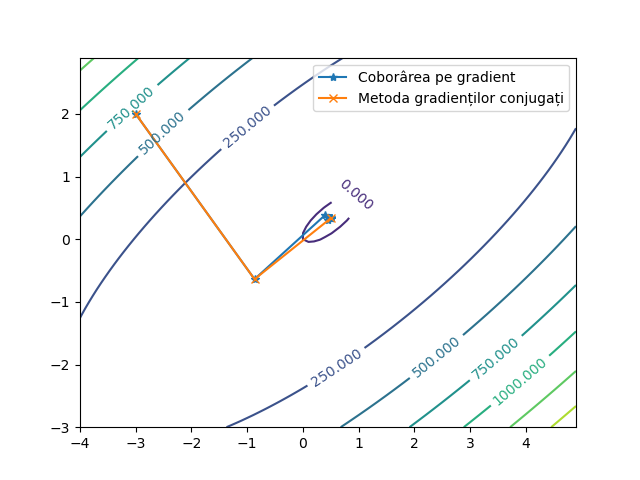

In [8]:
plt.figure('Curbe de nivel')

cs = plt.contour(X, Y, Z)
plt.clabel(cs)

pgd = np.array(points_gradient_descent)
plt.plot(pgd[:, 0], pgd[:, 1], marker='*', label='Coborârea pe gradient')

pcg = np.array(points_conjugate_gradient)
plt.plot(pcg[:, 0], pcg[:, 1], marker='x', label='Metoda gradienților conjugați')

plt.legend()
plt.show()

## 2. Interpolare cu polinoame Lagrange 

### Definirea funcției

Implementăm în Python funcția care trebuie interpolată:

In [9]:
def f(x):
    return -2 * np.sin(2 * x) + 2 * np.cos(- 3 * x) + 10.99 * x

# Intervalul pe care lucrăm
left = -np.pi
right = +np.pi

# Gradul polinomului rezultat
N = 20

### Alegerea polilor de interpolare

Pentru a evita erorile foarte mari în apropierea marginilor, vom folosi poli Chebysev.

In [10]:
def chebyshev(k):
    x = np.cos(np.pi * ((N - k) / N))
    return (left + right)/2 + ((right - left)/2) * x

x = np.array([chebyshev(k) for k in range(N + 1)])

# Evaluăm funcția în polii de interpolare
y = f(x)

### Construirea polinomului

Folosim formula lui Newton:

In [11]:
def compute_coefficient(k, t):
    """Calculează coeficientul termenului de ordin `k` în punctul `t`
    folosind metoda Newton.
    """
    terms = []
    for i in range(N + 1):
        if i != k:
            terms.append((t - x[i])/(x[k] - x[i]))
    return np.prod(terms)

def evaluate_polynomial(t):
    s = 0
    for i in range(N + 1):
        s += compute_coefficient(i, t) * y[i]
    return s

### Reprezentarea grafică

Eșantionăm funcția și polinomul într-un număr mult mai mare de puncte, pentru a vedea cât de bine o aproximează:

<IPython.core.display.Javascript object>


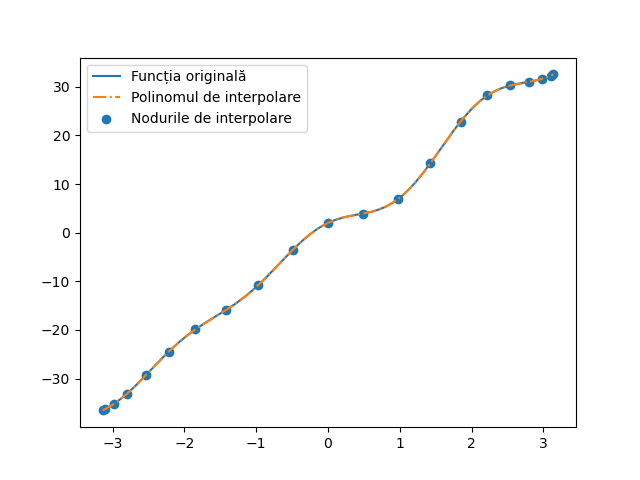

In [12]:
num_plot_points = 500
x_grafic = np.linspace(left, right, num_plot_points)
y_grafic = f(x_grafic)
y_interpolat = [evaluate_polynomial(t) for t in x_grafic]

plt.figure('Interpolare cu polinoame Lagrange')
plt.plot(x_grafic, y_grafic, label='Funcția originală')

plt.plot(x_grafic, y_interpolat, linestyle='-.', label='Polinomul de interpolare')

plt.scatter(x, y, label='Nodurile de interpolare')

plt.legend()
plt.show()

### Eroarea de trunchiere

Definesc o funcție pentru afișarea erorii de trunchiere (va fi folosită și la 3):

In [13]:
def plot_truncation_error(y_real, y_approx):
    error = np.abs(y_real - y_approx)
    max_error = np.max(error)

    plt.plot(x_grafic, error)
    plt.hlines(1e-5, xmin=left, xmax=right, color='red')
    plt.hlines(max_error, label='Eroarea maximă', xmin=left, xmax=right, color='orange')
    plt.legend()

Afișăm eroarea de trunchiere, și vedem că este sub $10^{-5}$:

<IPython.core.display.Javascript object>


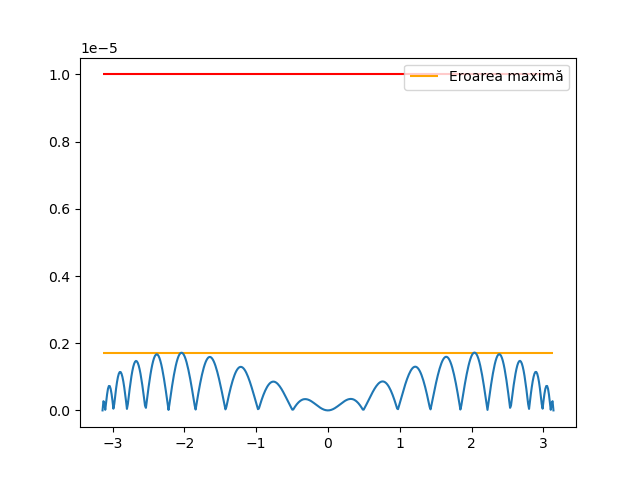

In [14]:
plt.figure('Eroare interpolare cu polinoame Lagrange')
plot_truncation_error(y_grafic, y_interpolat)
plt.show()

## 3. Interpolare cu funcții spline cubice

### Definirea funcției

In [15]:
def f(x):
    return 1 * np.sin(-5 * x) + 6 * np.cos(-5 * x) - 10.24 * x

def f_derivative(x):
    return -5 * np.cos(-5 * x) + 30 * np.sin(-5 * x) - 10.24

# Intervalul pe care lucrăm
left = -np.pi
right = np.pi

# Numărul de subintervale
N = 199

Împărțim domeniul de definiție în $N$ intervale de lungimi egale, și evaluăm funcția în nodurile de interpolare:

In [16]:
x = np.linspace(left, right, N + 1)
y = f(x)

### Determinarea funcțiilor spline

Coeficienții $a_i$ se pot obține direct:

In [17]:
a = y.copy()

Coeficienții $b_i$ se obțin rezolvând un sistem de ecuații liniare:

In [18]:
B = np.zeros((N + 1, N + 1))

B[0, 0] = 1
for i in range(1, N):
    B[i, i - 1] = 1
    B[i, i] = 4
    B[i, i + 1] = 1
B[N, N] = 1

h = x[1] - x[0]

W = np.zeros((N + 1, 1))
W[0] = f_derivative(x[0])
for i in range(1, N):
    W[i] = 3 * (y[i + 1] - y[i - 1]) / h
W[N] = f_derivative(x[N])

b = np.linalg.solve(B, W)

Coeficienții $c_i$ și $d_i$ se obțin din $b$-uri:

In [19]:
c = np.zeros(N)
d = np.zeros(N)

h_squared = h * h
h_cubed = h * h * h

for i in range(N):
    c[i] = 3 * (y[i + 1] - y[i]) / h_squared - (b[i + 1] + 2 * b[i]) / h
    d[i] = - 2 * (y[i + 1] - y[i]) / h_cubed + (b[i + 1] + b[i]) / h_squared

Definesc o funcție care generează funcțiile spline $S_i$:

In [20]:
def construct_spline(i):
    def spline(t):
        T = t - x[i]
        return a[i] + b[i] * T + c[i] * (T ** 2) + d[i] * (T ** 3)
    return spline

### Reprezentarea grafică

Evaluăm funcția originală și funcțiile spline cubice care o interpolează pe un număr mai mare de puncte, pentru a compara precizia:

<IPython.core.display.Javascript object>


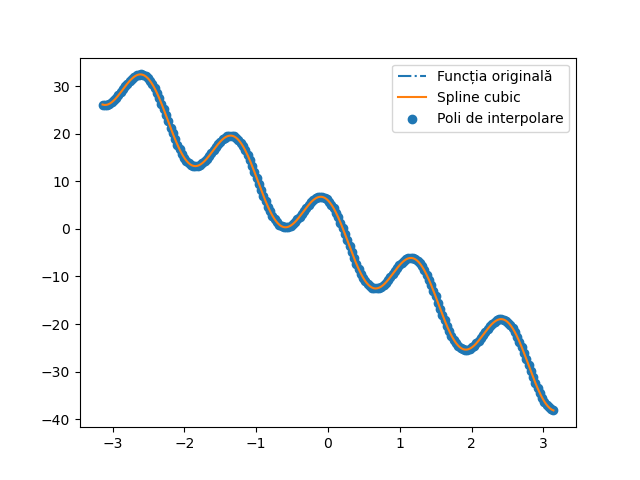

In [21]:
num_plot_points = 500
x_grafic = np.linspace(left, right, num_plot_points)
y_grafic = f(x_grafic)

y_aproximat = np.piecewise(
    x_grafic,
    [
        (x[i] <= x_grafic) & (x_grafic < x[i + 1])
        for i in range(N - 1)
    ],
    [
        construct_spline(i)
        for i in range(N)
    ]
)

plt.figure('Interpolare cu funcții spline cubice')

plt.plot(x_grafic, y_grafic, linestyle='-.', label='Funcția originală')
plt.plot(x_grafic, y_aproximat, label='Spline cubic')
plt.scatter(x, y, label='Poli de interpolare')

plt.legend()
plt.show()

### Eroarea de trunchiere

<IPython.core.display.Javascript object>


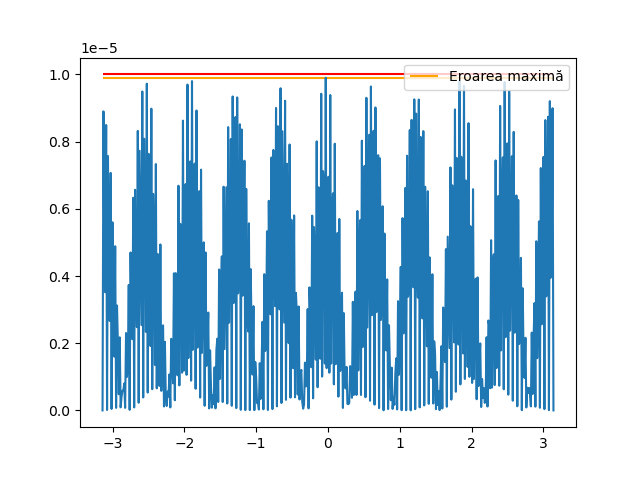

In [22]:
plt.figure('Eroare interpolare cu funcții spline cubice')
plot_truncation_error(y_grafic, y_aproximat)
plt.show()